In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, classification_report
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier, plot_importance

# Used for Confusion Matrix
from sklearn import metrics
import matplotlib.pyplot as plt


In [2]:
# Adapted from: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [3]:
# load dataset
dataset = read_csv('D:/nils/projects/dissertation/dataset_exp3_train.csv', header=0, index_col=False)
#dataset = df
dataset

,y,asa_high_cpu_Prod126,extremely_long_cpu_hog,long_cpu_hog_Prod126,memory_used_greater_than_100percent_Prod334,snmp_cpu_hog_Prod126,hit_severity
0,0,0,0,1,0,0,0
1,0,1,0,0,0,0,0
2,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...
378542,0,0,0,0,1,0,0
378543,0,1,0,0,0,0,0
378544,0,0,0,1,0,0,0
378545,0,0,1,0,0,0,0


In [4]:
dataset.sum()

y                                               4642
asa_high_cpu_Prod126                           69931
extremely_long_cpu_hog                         64907
long_cpu_hog_Prod126                           73927
memory_used_greater_than_100percent_Prod334    66433
snmp_cpu_hog_Prod126                           67691
hit_severity                                   35443
dtype: int64

In [5]:
# Adapted from: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
# This normalises the severity -  other variables are already binary factors so re not impacted

# specify the look Back
n_look_back = 100
n_features = len(dataset.columns)

values = dataset.values

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)



# Creates time series dataframe
# frame as supervised learning
reframed = series_to_supervised(scaled, n_look_back, 1)
print(reframed.shape)
reframed

(378447, 707)


,var1(t-100),var2(t-100),var3(t-100),var4(t-100),var5(t-100),var6(t-100),var7(t-100),var1(t-99),var2(t-99),var3(t-99),...,var5(t-1),var6(t-1),var7(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t)
100,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
101,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
102,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
104,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
378543,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
378544,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
378545,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [6]:
# split into train and test sets
values = reframed.values
n_train_hours = int(reframed.shape[0]*.7)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_look_back * n_features
x_train, y_train = train[:, :n_obs], train[:, -n_features]
x_test, y_test = test[:, :n_obs], test[:, -n_features]
print(x_train.shape, len(x_train), y_train.shape)

x_train_2d = x_train
x_test_2d = x_test

## reshape input to be 3D [samples, timesteps, features]
#x_train = x_train.reshape((x_train.shape[0], n_look_back, n_features))
#x_test = x_test.reshape((x_test.shape[0], n_look_back, n_features))
#print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

x_train 

n_train_hours

(264912, 700) 264912 (264912,)


264912

In [7]:
# XGBOOST CLASSIFIER
# GPU setting tree_method='gpu_hist'

In [8]:
classifier = XGBClassifier(max_depth=6, 
                     eta=0.1,
                     verbosity=2,
                     objective='binary:logistic',
                     tree_method='gpu_hist',
                     n_estimators=1000,
                     learning_rate=0.05).fit(x_train_2d, y_train, eval_metric='auc')

In [9]:
# save model to file
import pickle
pickle.dump(classifier, open("xgb.exp2.pickle.dat", "wb"))

In [10]:
pred_y_class = classifier.predict(x_test_2d)
pred_y_prob = classifier.predict_proba(x_test_2d)
pred_y_prob = pred_y_prob[:, 1]

In [11]:
def cm(y_test, pred_y_class):
    cm = metrics.confusion_matrix(y_test, pred_y_class)
    fn = cm[1][0]
    tp = cm[1][1]
    fnr = fn/(tp+fn)
    return cm, fnr

In [12]:
cmXGB1, fnrXGB1 = cm(y_test, pred_y_class)
print(cmXGB1)
fnrXGB1

[[112658     32]
 [   830     15]]


0.9822485207100592

In [13]:
classifier.score(x_train_2d, y_train)

0.9992035090898109

In [14]:
print(classification_report(y_test, pred_y_class))

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00    112690
         1.0       0.32      0.02      0.03       845

    accuracy                           0.99    113535
   macro avg       0.66      0.51      0.51    113535
weighted avg       0.99      0.99      0.99    113535



In [15]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score, matthews_corrcoef
 
F1_XGB = f1_score(y_test, pred_y_class)
MCC_XGB = matthews_corrcoef(y_test,pred_y_class)

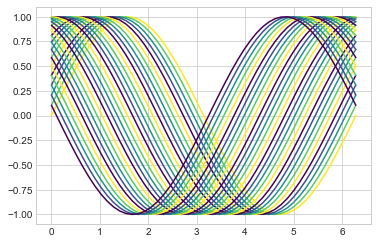

In [16]:
pr_XGB, re_XGB, th = precision_recall_curve(y_test, pred_y_prob)

import matplotlib.pyplot as plt
from cycler import cycler
import numpy as np

plt.style.use('seaborn-whitegrid')

# get colormap
cmap=plt.cm.viridis_r
# build cycler with 5 equally spaced colors from that colormap
c = cycler('color', cmap(np.linspace(0,1,5)) )
# supply cycler to the rcParam
plt.rcParams["axes.prop_cycle"] = c


x = np.linspace(0,2*np.pi)
f = lambda x, phase:np.sin(x+phase)
for i in range(30):
    plt.plot(x,f(x,i/30.*np.pi) )

plt.show()

In [17]:
#LOAD IN TEST SET FROM ANOTHER SET OF CUSTOMERS

In [18]:
# load dataset
dataset_test = read_csv('D:/nils/projects/dissertation/dataset_exp3_test.csv', header=0, index_col=False)
#dataset = df
dataset_test.sum()

y                                               69643
asa_high_cpu_Prod126                            70733
extremely_long_cpu_hog                          70730
long_cpu_hog_Prod126                           133420
memory_used_greater_than_100percent_Prod334     70732
snmp_cpu_hog_Prod126                            70733
hit_severity                                   202033
dtype: int64

In [19]:
# Adapted from: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
# This normalises the severity -  other variables are already binary factors so re not impacted

# specify the look Back
n_look_back = 100
n_features = len(dataset_test.columns)

values = dataset_test.values

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)



# Creates time series dataframe
# frame as supervised learning
reframed = series_to_supervised(scaled, n_look_back, 1)
print(reframed.shape)
reframed

(416248, 707)


,var1(t-100),var2(t-100),var3(t-100),var4(t-100),var5(t-100),var6(t-100),var7(t-100),var1(t-99),var2(t-99),var3(t-99),...,var5(t-1),var6(t-1),var7(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t)
100,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
101,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
102,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
103,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
104,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416343,0.0,0.0,0.0,1.0,0.0,0.0,0.5,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
416344,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
416345,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
416346,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.5


In [20]:
# split into train and test sets
values = reframed.values
n_train_hours = int(reframed.shape[0]*.01)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_look_back * n_features
x_train2, y_train2 = train[:, :n_obs], train[:, -n_features]
x_test2, y_test2 = test[:, :n_obs], test[:, -n_features]
print(x_train.shape, len(x_train), y_train.shape)


x_train_2d2 = x_train2
x_test_2d2 = x_test2

# reshape input to be 3D [samples, timesteps, features]
#x_train = x_train.reshape((x_train.shape[0], n_look_back, n_features))
#x_test = x_test.reshape((x_test.shape[0], n_look_back, n_features))
#print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

#x_train 

#x_test

#n_train_hours

(264912, 700) 264912 (264912,)


In [21]:
# load model from file
loaded_classifier = pickle.load(open("xgb.exp2.pickle.dat", "rb"))

In [22]:
pred_y_class2 = loaded_classifier.predict(x_test_2d2)
pred_y_prob2 = loaded_classifier.predict_proba(x_test_2d2)
pred_y_prob2 = pred_y_prob2[:, 1]

In [23]:
cmXGB2, fnrXGB2 = cm(y_test2, pred_y_class2)
print(cmXGB2)
fnrXGB2

[[337874   5373]
 [ 65902   2937]]


0.957335231482154

In [24]:
print(classification_report(y_test2, pred_y_class2))

              precision    recall  f1-score   support

         0.0       0.84      0.98      0.90    343247
         1.0       0.35      0.04      0.08     68839

    accuracy                           0.83    412086
   macro avg       0.60      0.51      0.49    412086
weighted avg       0.76      0.83      0.77    412086



In [25]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score, matthews_corrcoef
 
F1_XGB2 = f1_score(y_test2, pred_y_class2)
MCC_XGB2 = matthews_corrcoef(y_test2,pred_y_class2)


pr_XGB2, re_XGB2, th = precision_recall_curve(y_test2, pred_y_prob2)


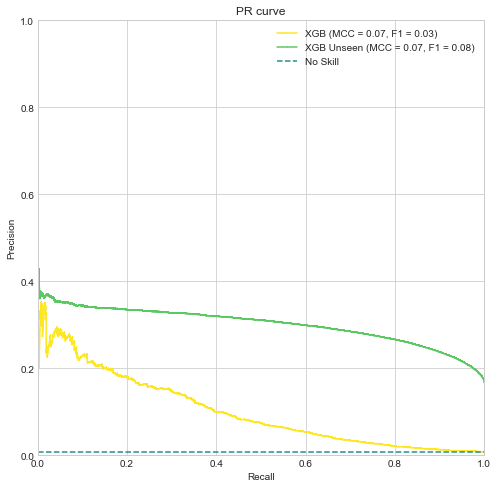

In [26]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score, matthews_corrcoef
 
F1_XGB2 = f1_score(y_test2, pred_y_class2)
MCC_XGB2 = matthews_corrcoef(y_test2,pred_y_class2)


pr_XGB2, re_XGB2, th = precision_recall_curve(y_test2, pred_y_prob2)

plt.figure(figsize=(8,8))
# calculate the no skill line as the proportion of the positive class
no_skill = len(y_test[y_test==1]) / len(y_test)
# plot the no skill precision-recall curve
pyplot.plot(re_XGB, pr_XGB, marker=',', label='XGB (MCC = {:.2f}, F1 = {:.2f})'.format(MCC_XGB, F1_XGB))
pyplot.plot(re_XGB2, pr_XGB2, marker=',', label='XGB Unseen (MCC = {:.2f}, F1 = {:.2f})'.format(MCC_XGB2, F1_XGB2))
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.xlabel('Recall')
plt.ylabel('Precison')
plt.title('PR curve')
plt.legend(loc='best')
# axis labels
plt.xlim(0,1)
plt.ylim(0,1)
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot

plt.savefig('prc_unseen_plot.svg', transparent=True)
plt.show()

<Figure size 432x288 with 0 Axes>

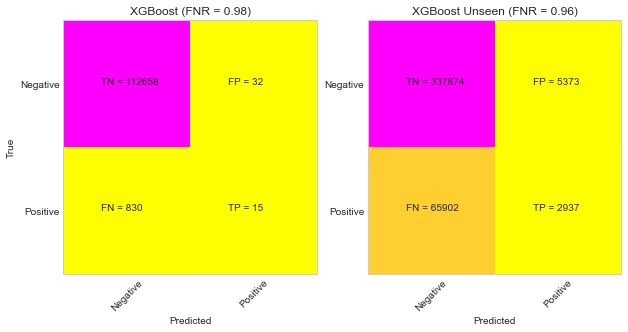

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

plt.clf()
G = gridspec.GridSpec(1, 2)
plt.figure(figsize=(10,5))

axes_4 = plt.subplot(G[0,0])
plt.imshow(cmXGB1, interpolation='nearest', cmap=plt.cm.spring_r)
classNames = ['Negative','Positive']
plt.title('XGBoost (FNR = {:.2f})'.format(fnrXGB1))
plt.ylabel('True')
plt.grid(b=None)
plt.xlabel('Predicted')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j-0.2,i, str(s[i][j])+" = "+str(cmXGB1[i][j]))

axes_1 = plt.subplot(G[0,1])
plt.imshow(cmXGB2, interpolation='nearest', cmap=plt.cm.spring_r)
classNames = ['Negative','Positive']
plt.title('XGBoost Unseen (FNR = {:.2f})'.format(fnrXGB2))
#plt.ylabel('True')
plt.xlabel('Predicted')
plt.grid(b=None)
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j-0.2,i, str(s[i][j])+" = "+str(cmXGB2[i][j]))
               
plt.savefig('cm_unseen_plot.svg', transparent=True)
plt.show()
